In [44]:

import pandas as pd
import numpy as np
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import platform
import datetime
if platform.system() == 'Windows':
# 윈도우인 경우
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
# Mac 인 경우
    rc('font', family='AppleGothic')

In [2]:
sales= pd.read_excel('/content/2020 빅콘테스트 데이터분석분야-챔피언리그_2019년 실적데이터.xlsx',header =1)
view_rate = pd.read_excel("/content/2020 빅콘테스트 데이터분석분야-챔피언리그_시청률 데이터.xlsx",header =1, index_col= 0)

In [3]:
#2020-01-01 제외
sales=sales[:-9]

In [4]:
def count(t1,t2):
    t1= datetime.datetime.strptime(t1, '%H:%M')
    t2= datetime.datetime.strptime(t2, '%H:%M')
    if(int(str(t2-t1).split(':')[0][-1])>0):
      c=60
    else:
      c=int(str(t2-t1).split(':')[1])
    return c-1

In [5]:
vr = list(sales['방송일시'])

#방송일시 type Timestamp -> 문자열로 처리
for i in range(len(vr)):
  vr[i] = str(vr[i]).replace('Timestamp(','').replace(')','').strip()

In [6]:
#방송일시에서 날짜와 시간대를 분리하여 시간대 평균 시청률 매칭하기
for i in range(len(vr)):
  date = vr[i].split(' ')[0]

  if(i<len(vr)-4): #19-12-31 23:40분 제외
    t1 = vr[i].split(' ')[1][:5] #시간
    #다음 방영 시간대 계산
    def next(t1):
      j=i
      t2 = vr[j+1].split(' ')[1][:5]
      while(t1==t2):
        j=j+1
        t2=vr[j+1].split(' ')[1][:5]
      return vr[j+1].split(' ')[1][:5] #다음 시간
    t2 = next(t1) 
 
  # 만약 다음 시간이 10분이면 
    if(t2[3:]=='10'): 
      time = t1[:3]+'09'
      vr[i]= view_rate[date].rolling(window=count(t1,t2)).mean()[time]
    elif(t1=='01:30'):
      vr[i]= view_rate[date].rolling(window=30).mean()['01:59']
    elif(t1=='01:40'):
      vr[i]= view_rate[date].rolling(window=20).mean()['01:59']
    elif(t1=='01:50'):
      vr[i]= view_rate[date].rolling(window=10).mean()['01:59']
  # 10분 아니면  
    else:
      hour=t1[:3] #시
      min= int(t1[3:])+count(t1,t2) 
      if(min>60): #만약 60분보다 큰 수가 나오면
        min=min-60 # 빼버리고
        if(min<10): #뺀 값이 한자리수 일 때
          min='0'+str(min)   
        new=int(hour[:2])+1# 시간은 +1
        
        if (new<10):
          new='0'+str(new)

        elif(new==24):  
          new='00'
        
        hour=str(new)+':'
      
      time = hour+str(min)
      
      vr[i]= view_rate[date].rolling(window=count(t1,t2)).mean()[time]
  
#12월 31일 11시 40분 처리
  else:
      vr[i]= view_rate[date].rolling(window=20).mean()[vr[i].split(' ')[1][:3]+'59']
     

In [7]:
sales['시청률'] = vr

In [8]:
# 무형 지우기
sales.drop(sales[sales["상품군"]=="무형"].index, inplace=True)

In [9]:
# 결측된 노출분 채우기
for i,row in sales.iterrows():
    val = row["노출(분)"]
    if i == 0 :
        continue
        
    if  np.isnan(val):
        if sales.loc[i,"방송일시"] == sales.loc[i-1,"방송일시"]:
            sales.loc[i,"노출(분)"] = sales.loc[i-1,"노출(분)"]
        else : 
            continue
            
sales.isnull().sum()


방송일시     0
노출(분)    0
마더코드     0
상품코드     0
상품명      0
상품군      0
판매단가     0
취급액      0
시청률      0
dtype: int64

In [10]:

# 판매단가 > 취급액 이면 취급액 = 0 

def custom(price, total):
    if price > total:
        return 0
    
    else:
        return total

sales["취급액"] = sales.apply(lambda x : custom(x["판매단가"], x["취급액"]), axis=1)

# 확인
print(sum((sales["판매단가"] > sales["취급액"]) & (sales['취급액'] != 0)))


0


In [12]:

# month, day, hour, minute, weekday 열 추가
sales['month'] = pd.DatetimeIndex(sales['방송일시']).month
sales['day'] = pd.DatetimeIndex(sales['방송일시']).day
sales['hour'] = pd.DatetimeIndex(sales['방송일시']).hour
sales['minute'] = pd.DatetimeIndex(sales['방송일시']).minute
sales['weekday'] = pd.DatetimeIndex(sales['방송일시']).weekday


In [11]:
sales['시청률'].value_counts(normalize=True)

0.000000e+00    0.168700
3.652049e-19    0.008858
7.304099e-19    0.005539
1.826025e-19    0.004442
1.460820e-18    0.004121
                  ...   
8.888889e-04    0.000027
2.526316e-03    0.000027
2.631579e-03    0.000027
5.555556e-04    0.000027
1.789474e-03    0.000027
Name: 시청률, Length: 9397, dtype: float64

심슨의 역설

In [13]:
sales['취급액'].corr(sales['시청률'])

0.07088930535578239

같은 시간대, 시청률과 매출액의 상관관계

In [15]:
def time(sales):
  date=[]
  time=[]

  for date_time in sales['방송일시']:
    date_time= str(date_time).replace('Timestamp(','').replace(')','').strip()
    date.append(date_time.split(' ')[0].replace('-',''))
    time.append(date_time.split(' ')[1][:-3])

  sales['date']= date
  sales['time']= time
  return sales

In [ ]:
time(sales)

In [17]:
corr_dic={}
for t in sales['time'].unique():
  t_table = sales[sales['time']==t]
  c= t_table['취급액'].corr(t_table['시청률'])
  corr_dic[t]=c
  print('{} 시간대의 시청률과 취급액의 상관관계는 {}'.format(t,c))

06:00 시간대의 시청률과 취급액의 상관관계는 -0.12983932137781096
06:20 시간대의 시청률과 취급액의 상관관계는 -0.02156836541379387
06:40 시간대의 시청률과 취급액의 상관관계는 0.08015255523261246
07:00 시간대의 시청률과 취급액의 상관관계는 0.10521049338955181
07:20 시간대의 시청률과 취급액의 상관관계는 0.11617312672830939
07:40 시간대의 시청률과 취급액의 상관관계는 0.09498702657455514
08:00 시간대의 시청률과 취급액의 상관관계는 -0.010311229905671725
08:20 시간대의 시청률과 취급액의 상관관계는 0.04891715688251753
08:40 시간대의 시청률과 취급액의 상관관계는 0.033761040858273916
09:00 시간대의 시청률과 취급액의 상관관계는 0.002599572329662253
09:20 시간대의 시청률과 취급액의 상관관계는 -0.041443650456047816
09:40 시간대의 시청률과 취급액의 상관관계는 0.024811220663214825
10:00 시간대의 시청률과 취급액의 상관관계는 0.06231432303395923
10:20 시간대의 시청률과 취급액의 상관관계는 0.13808315717574585
10:40 시간대의 시청률과 취급액의 상관관계는 0.022241788412131785
11:00 시간대의 시청률과 취급액의 상관관계는 0.13756200347046607
11:20 시간대의 시청률과 취급액의 상관관계는 -0.03447859752202569
12:00 시간대의 시청률과 취급액의 상관관계는 0.09433943738484245
12:20 시간대의 시청률과 취급액의 상관관계는 0.10194897903801932
12:40 시간대의 시청률과 취급액의 상관관계는 0.07338084564077149
13:00 시간대의 시청률과 취급액의 상관관계는 0.18259231494215558
13

/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2526: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar)
/usr/local/lib/python3.6/dist-packages/numpy/lib/function_base.py:2455: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


In [19]:
t_df= pd.DataFrame(corr_dic.values(),index=corr_dic.keys(),columns=['corr'])
t_df= t_df.sort_values(by=['corr'],ascending=False)

In [20]:
t_df['corr'].describe()

count    129.000000
mean       0.080342
std        0.322659
min       -0.990376
25%       -0.034479
50%        0.048917
75%        0.148706
max        1.000000
Name: corr, dtype: float64

In [ ]:
fig = plt.figure()
for i in t_df.index:
  t_table = sales[sales['time']==i]
  plt.scatter(t_table['시청률'],t_table['취급액'], alpha=0.4)
  plt.xlabel("viewrate")
  plt.ylabel("sales")
  plt.show()

같은 카테고리 시청률과 매출액의 상관관계

In [35]:
cat_corr_dic={}
for cat in sales['상품군'].unique():
  cat_table = sales[sales['상품군']==cat]
  c= cat_table['취급액'].corr(cat_table['시청률'])
  cat_corr_dic[cat]=c
  print('{} 상품군에서 시청률과 취급액의 상관관계는 {}'.format(cat,c))

의류 상품군에서 시청률과 취급액의 상관관계는 0.07470339355232322
속옷 상품군에서 시청률과 취급액의 상관관계는 0.07209947472638202
주방 상품군에서 시청률과 취급액의 상관관계는 0.12681673568511156
농수축 상품군에서 시청률과 취급액의 상관관계는 0.053577914742812836
이미용 상품군에서 시청률과 취급액의 상관관계는 0.03843371116505158
가전 상품군에서 시청률과 취급액의 상관관계는 0.04233148035891036
생활용품 상품군에서 시청률과 취급액의 상관관계는 -0.017604901094852684
건강기능 상품군에서 시청률과 취급액의 상관관계는 0.11111909351362784
잡화 상품군에서 시청률과 취급액의 상관관계는 0.036173624125035386
가구 상품군에서 시청률과 취급액의 상관관계는 0.02449587720420331
침구 상품군에서 시청률과 취급액의 상관관계는 0.01931685284597082


In [38]:
cat_df= pd.DataFrame(cat_corr_dic.values(),index=cat_corr_dic.keys(),columns=['corr'])
cat_df= cat_df.sort_values(by=['corr'],ascending=False)

In [39]:
cat_df['corr'].describe()

count    11.000000
mean      0.052860
std       0.041478
min      -0.017605
25%       0.030335
50%       0.042331
75%       0.073401
max       0.126817
Name: corr, dtype: float64

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51452 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48169 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49884 missing from current font.
  font.set_

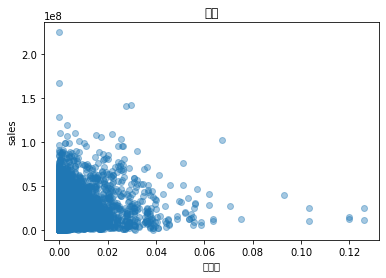

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44592 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45733 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44148 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44053 missing from current font.
  font.set_te

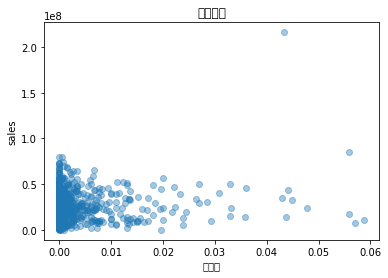

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47448 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51032 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 47448 missing from current font.
  font.set_text(s, 0, flags=flags)


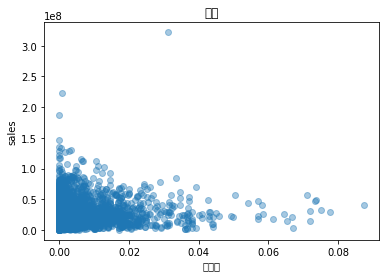

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50743 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49549 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50743 missing from current font.
  font.set_text(s, 0, flags=flags)


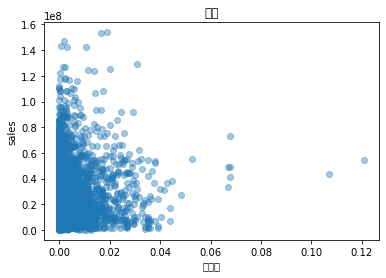

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 45453 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52629 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 45453 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49688 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52629 missing from current font.
  font.set_text

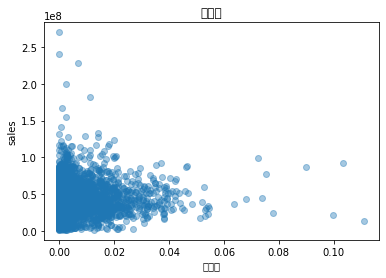

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44032 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51204 missing from current font.
  font.set_text(s, 0, flags=flags)


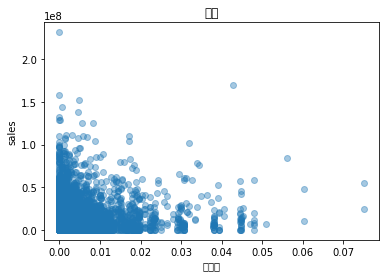

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 48120 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51060 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 48120 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 50857 missing from current font.
  font.set_text

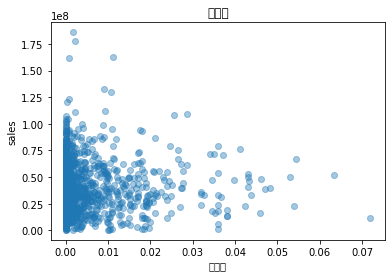

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51105 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 51105 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54868 missing from current font.
  font.set_text(s, 0, flags=flags)


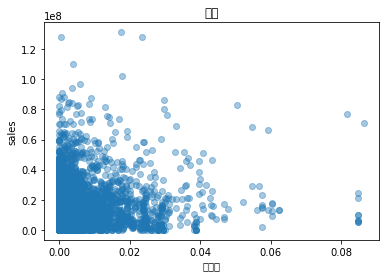

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 44396 missing from current font.
  font.set_text(s, 0, flags=flags)


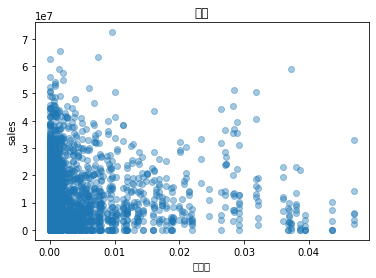

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 52840 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 52840 missing from current font.
  font.set_text(s, 0, flags=flags)


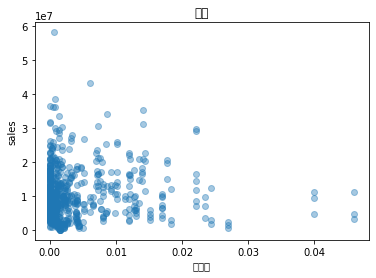

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 49373 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54876 missing from current font.
  font.set_text(s, 0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 54408 missing from current font.
  font.set_text

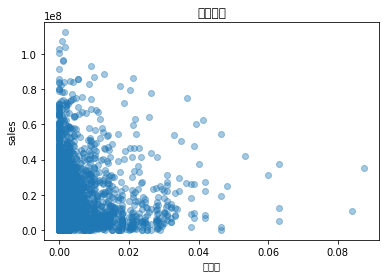

In [43]:
fig = plt.figure()
for i in cat_df.index:
  t_table = sales[sales['상품군']==i]
  plt.scatter(t_table['시청률'],t_table['취급액'], alpha=0.4)
  plt.xlabel("시청률")
  plt.ylabel("sales")
  plt.title(i)
  plt.show()

기존

In [15]:
from sklearn.model_selection import train_test_split
x = sales[['노출(분)', '시청률']]
y = sales[['취급액']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)


In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_predicted = model.predict(x_test)

In [ ]:
print(model.intercept_)
print(model.coef_[[0]])

[17092178.73951696]
[[1.95549171e+05 1.70261238e+08]]


In [ ]:
#잔차
residuals =y_test-y_predicted
residuals.describe()

,취급액
count,7.474000e+03
mean,8.033338e+04
std,2.015096e+07
min,-3.066212e+07
25%,-1.479543e+07
50%,-5.489877e+06
75%,1.005279e+07
max,2.107858e+08


In [ ]:
# 적합도 검증 - 결정계수
SSE = (residuals**2).sum()
SST = ((y_test-y_test.mean())**2).sum()
R_squared = 1 - (SSE/SST)
print('R_squared = ', R_squared)

R_squared =  취급액    0.005544
dtype: float64


In [ ]:
from sklearn.metrics import mean_squared_error
print('score = ',model.score(X = x, y=y))
print('Mean_Squared_Error = ', mean_squared_error(y_predicted, y_test))
print('RMSE = ', mean_squared_error(y_predicted, y_test)**0.5)
#오차가...

score =  0.0056759250078922685
Mean_Squared_Error =  406013410403817.94
RMSE =  20149774.450445294


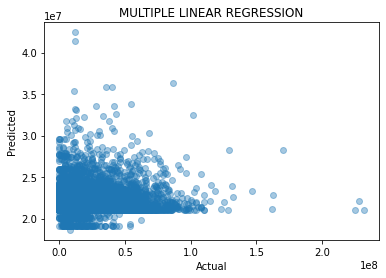

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predicted, alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [ ]:
x_test['노출(분)'].size

7474

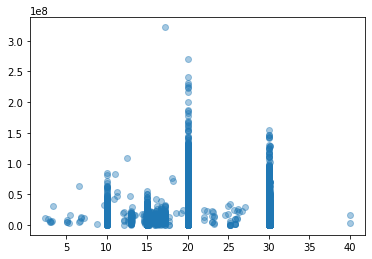

In [ ]:
plt.scatter(sales['노출(분)'], sales['취급액'], alpha=0.4)
plt.show()

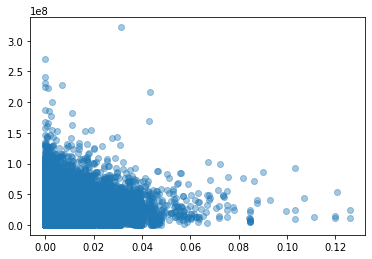

In [ ]:
plt.scatter(sales['시청률'], sales['취급액'], alpha=0.4)
plt.show()

In [ ]:
sales['취급액'].describe()

count    3.736800e+04
mean     2.186696e+07
std      2.018984e+07
min      0.000000e+00
25%      6.880000e+06
50%      1.612850e+07
75%      3.162475e+07
max      3.220090e+08
Name: 취급액, dtype: float64

In [ ]:
sales['노출(분)'].describe()

count    37368.000000
mean        20.384069
std          3.122025
min          2.466667
25%         20.000000
50%         20.000000
75%         20.000000
max         40.000000
Name: 노출(분), dtype: float64

In [ ]:
sales['시청률'].describe()

count    3.736800e+04
mean     4.537890e-03
std      8.181684e-03
min      0.000000e+00
25%      3.652049e-18
50%      1.315789e-03
75%      5.157895e-03
max      1.259474e-01
Name: 시청률, dtype: float64

**시청률 높은 애들 대상으로...?**

In [ ]:
vr_high =sales[sales['시청률']>=5.157895e-03]

In [ ]:
from sklearn.model_selection import train_test_split
x = vr_high[['노출(분)', '시청률']]
y = vr_high[['취급액']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_predicted = model.predict(x_test)

In [ ]:
print(model.intercept_)
print('노출시간, 시청률 : ', model.coef_[[0]])

[20882362.00527507]
노출시간, 시청률 :  [[  102014.69652529 75828382.39389929]]


In [ ]:
#잔차
residuals =y_test-y_predicted
residuals.describe()

,취급액
count,1.861000e+03
mean,4.045479e+05
std,2.250345e+07
min,-2.687135e+07
25%,-1.630235e+07
50%,-5.249698e+06
75%,1.094074e+07
max,2.047333e+08


In [ ]:
# 적합도 검증 - 결정계수
SSE = (residuals**2).sum()
SST = ((y_test-y_test.mean())**2).sum()
R_squared = 1 - (SSE/SST)
print('R_squared = ', R_squared)

R_squared =  취급액    0.002327
dtype: float64


In [ ]:
from sklearn.metrics import mean_squared_error
print('score = ',model.score(X = x, y=y))
print('Mean_Squared_Error = ', mean_squared_error(y_predicted, y_test))
print('RMSE = ', mean_squared_error(y_predicted, y_test)**0.5)


score =  0.0018966043024239987
Mean_Squared_Error =  506296705961482.56
RMSE =  22501037.886317212


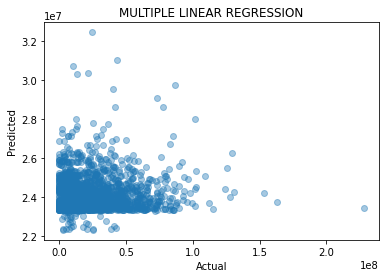

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predicted, alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

**노출시간 높은 애들 대상으로..?**

In [ ]:
vt_high =sales[sales['노출(분)']>=30]

In [ ]:
from sklearn.model_selection import train_test_split
x = vt_high[['노출(분)', '시청률']]
y = vt_high[['취급액']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)

from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_predicted = model.predict(x_test)

In [ ]:
print(model.intercept_)
print('노출시간, 시청률 : ', model.coef_[[0]])

[1.45489631e+08]
노출시간, 시청률 :  [[-4137936.75724962 49244867.3183258 ]]


In [ ]:
#잔차
residuals =y_test-y_predicted
residuals.describe()

,취급액
count,5.260000e+02
mean,-2.413549e+05
std,2.328971e+07
min,-2.326698e+07
25%,-1.713153e+07
50%,-9.217528e+06
75%,1.028034e+07
max,1.253500e+08


In [ ]:
# 적합도 검증 - 결정계수
SSE = (residuals**2).sum()
SST = ((y_test-y_test.mean())**2).sum()
R_squared = 1 - (SSE/SST)
print('R_squared = ', R_squared)

R_squared =  취급액    0.003724
dtype: float64


In [ ]:
from sklearn.metrics import mean_squared_error
print('score = ',model.score(X = x, y=y))
print('Mean_Squared_Error = ', mean_squared_error(y_predicted, y_test))
print('RMSE = ', mean_squared_error(y_predicted, y_test)**0.5)


score =  0.003555027901740005
Mean_Squared_Error =  541437805419853.06
RMSE =  23268816.1585383


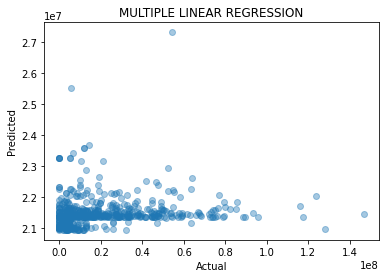

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predicted, alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

**다항 회귀**

In [ ]:
vr_high_poly =vr_high

In [ ]:
from sklearn.model_selection import train_test_split
x = vr_high_poly[['시청률']]
y = vr_high_poly[['취급액']]
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2)


In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly_features = PolynomialFeatures(degree=2, include_bias=False)
X = poly_features.fit_transform(x)
X_poly_train = poly_features.fit_transform(x_train)
X_poly_test = poly_features.fit_transform(x_test)

In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_poly_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [ ]:
y_predicted = model.predict(X_poly_test)

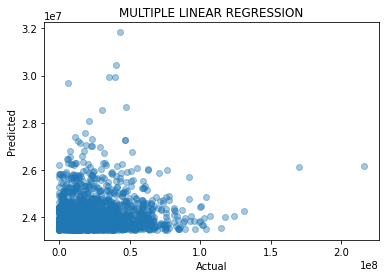

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(y_test, y_predicted, alpha=0.4)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("MULTIPLE LINEAR REGRESSION")
plt.show()

In [ ]:
#잔차
residuals =y_test-y_predicted
residuals.describe()

,취급액
count,1.861000e+03
mean,2.366687e+05
std,2.152612e+07
min,-2.620261e+07
25%,-1.604564e+07
50%,-5.505842e+06
75%,1.071121e+07
max,1.898869e+08


In [ ]:
from sklearn.metrics import mean_squared_error
print('score = ',model.score(X = X, y=y))
print('Mean_Squared_Error = ', mean_squared_error(y_predicted, y_test))
print('RMSE = ', mean_squared_error(y_predicted, y_test)**0.5)

score =  0.0016714651037895711
Mean_Squared_Error =  463180886894424.3
RMSE =  21521637.644343525
